In [23]:
!rm -rf Eunomia
!git clone https://github.com/ouaguenouni/Eunomia
!pip install -r Eunomia/requirements.txt

Cloning into 'Eunomia'...
remote: Enumerating objects: 509, done.
remote: Counting objects: 100% (509/509), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 509 (delta 379), reused 437 (delta 307), pack-reused 0
Receiving objects: 100% (509/509), 3.27 MiB | 2.23 MiB/s, done.
Resolving deltas: 100% (379/379), done.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Eunomia.preferences import *
from Eunomia.additive_functions import *
from Eunomia.alternatives import *
from Eunomia.sampling import *
from Eunomia.mcmc import *
from Eunomia.degree import *
from Eunomia.experiments import *
pyro.set_rng_seed(1)

In [21]:
N_CHAMBERS = 2

#suffrages = np.random.randint(0,100,(N_CHAMBERS, N_PARTYS)).astype(float)

suffrages = np.array([
        np.array([100, 25, 15]),
        np.array([100, 15, 25]),
])

N_PARTYS = suffrages.shape[1]

def linear_scaling(x):
    return x / x.sum()

def pol_scaling(x , degree = 3):
    y = np.power(x, degree)
    return y / y.sum()


def scale(suffrages, scaling_functions):
    nsf = []
    for i in range(suffrages.shape[0]):
        nsf.append(scaling_functions[i](suffrages[i, :]))
    return np.array(nsf)

def evaluate_coalition(coalition, effectifs):
    return np.where(effectifs[:, coalition].sum(axis = 1) > 0.5)[0].shape[0]

def compute_data(n_partis, evaluation_function, effectifs):
    alternatives = [sparse_to_alt(tuple(i), n_partis) for i in generate_additive_theta(n_partis,n_partis - 1)]
    theta = [tuple(i) for i in generate_additive_theta(n_partis,n_partis-1)]
    ranks = []
    for a in alternatives:
        ranks.append(evaluation_function(alt_to_sparse(a), effectifs))
    alternatives = np.array(alternatives)
    ranks = np.array(ranks)
    preferences = PreferenceModel(alternatives, ranks)
    print(ranks)
    print(alternatives)
    data = preferences.generate_preference_matrix(theta)
    data = torch.tensor(data).float()
    return data ,theta


In [22]:
effectifs = scale(suffrages, [linear_scaling, linear_scaling])
data, theta = compute_data(effectifs.shape[1], evaluate_coalition,effectifs)
data

[2 0 0 2 2 0]
[[1 0 0]
 [0 1 0]
 [0 0 1]
 [1 1 0]
 [1 0 1]
 [0 1 1]]


tensor([[ 1., -1.,  0.,  0.,  0.,  0.],
        [ 1.,  0., -1.,  0.,  0.,  0.],
        [ 1., -1., -1.,  0.,  0., -1.],
        [ 1.,  0.,  0.,  1.,  0.,  0.],
        [ 1.,  1., -1.,  1.,  0.,  0.],
        [ 1.,  0., -1.,  1.,  0., -1.],
        [ 1., -1.,  1.,  0.,  1.,  0.],
        [ 1.,  0.,  0.,  0.,  1.,  0.],
        [ 1., -1.,  0.,  0.,  1., -1.]])

In [8]:
sigma_w = 1e-1
sigma_p = 1
n_samples = 1500

model = posterior_sampling_model(data, sigma_w=sigma_w, sigma_p=sigma_p)
diag, sampled_weights, sigmas = sample_model(model, data, "w", "sigma", warmup_steps=1000, num_samples=n_samples, return_diag=True)

Sample: 100%|████████████████████████████| 2500/2500 [01:09, 35.89it/s, step size=3.13e-01, acc. prob=0.831]


(array([   3.,    5.,    6.,    6.,   15.,   19.,   34.,   72.,  160.,
        1180.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

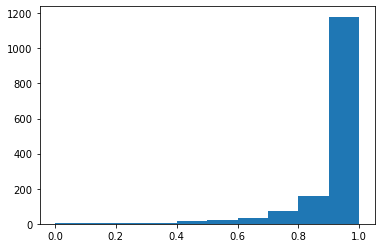

In [9]:
accs_d = get_acc_distribution(data, sampled_weights, sigmas)
plt.hist(accs_d)

In [14]:
svs = np.array([compute_semivalues(N_PARTYS, theta, weights, lambda x:1)[::-1] for weights in sampled_weights])

In [15]:
means, stds = svs.mean(axis = 0), svs.std(axis = 0)

In [16]:
np.argsort(means)

array([1, 0, 2])

In [17]:
sampled_weights

tensor([[ 0.2509, -0.0797, -0.0745, -0.0112,  0.0384,  0.1015],
        [ 0.2326, -0.0264, -0.0136, -0.1377,  0.0770,  0.0391],
        [ 0.1050, -0.1018, -0.0665,  0.0671, -0.1266, -0.0564],
        ...,
        [ 0.1875,  0.0103, -0.0495, -0.0903, -0.1142, -0.0341],
        [ 0.1065,  0.0124, -0.0456,  0.0620,  0.1265, -0.1080],
        [ 0.0901, -0.0195, -0.0636,  0.0207,  0.1213, -0.1739]])

In [18]:
means

array([-0.10968828, -0.1162744 ,  0.69648422])